In [1]:
import sys
import os
from pathlib import Path

# 获取当前工作目录，然后向上导航到 src 目录
current_dir = Path(os.getcwd())
# 假设当前在 code/src/learn 目录下，需要回到 code/src
src_path = current_dir.parent if current_dir.name == "learn" else current_dir
sys.path.insert(0, str(src_path))

from pprint import pprint  # noqa: E402
from utils.model import base  # noqa: E402
import numpy as np  # noqa: E402
import time  # noqa: E402

import torch.nn as nn  # noqa: E402
import torch  # noqa: E402


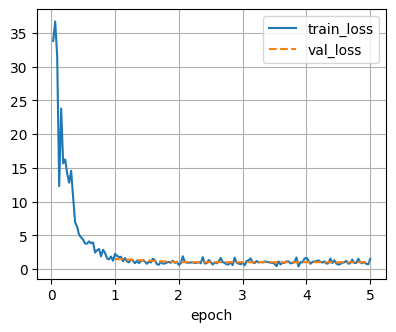

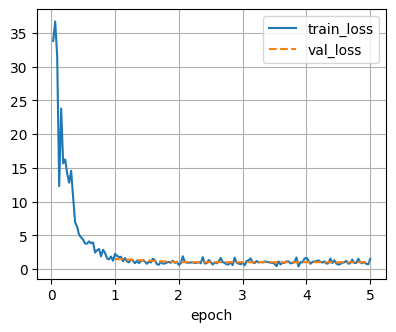

In [2]:
from torch.utils.data import TensorDataset, DataLoader
# --- 1. 定义具体的模型 ---
class LinearRegression(base.ModernModule):
    def __init__(self, config: base.ModelConfig):
        super().__init__(config)
        # 实际的网络
        self.net = nn.LazyLinear(1)
        # 初始化权重
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def loss(self, y_hat, y):
        # 均方误差损失
        return nn.functional.mse_loss(y_hat, y.reshape(y_hat.shape))

# --- 2. 准备数据 (示例) ---
true_w = torch.tensor([2, -3.4])
true_b = 4.2
X = torch.randn(1000, 2)
y = torch.mv(X, true_w) + true_b
y += torch.randn(y.shape)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset, batch_size=32)

# --- 3. 组装并开始训练 ---
# 创建配置
config = base.ModelConfig(lr=0.03)
# 创建模型
model = LinearRegression(config)
# 创建回调
plotting_callback =base.PlottingCallback()
# 创建训练器
trainer = base.Trainer(max_epochs=5, callbacks=[plotting_callback])

# 开始训练！
trainer.fit(model, train_loader, val_loader)

In [14]:
import utils.dataset as ds

config = base.ModelConfig(
    lr=0.03,
    num_hiddens=256,
)


class SoftMaxRegression(base.ModernModule):
    def __init__(self, config: base.ModelConfig):
        super().__init__(config)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10),  # 假设有10个类别
        )

    def loss(self, y_hat, y):
        # 使用交叉熵损失
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, X):
        # 返回预测的类别
        return self.net(X).argmax(dim=1)

    def predict_class(self, X):
        # 返回预测的类别
        return self.predict(X).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


datapath = "../../data/"

ds_downloader = ds.DataDownloader(data_root=datapath)
ds_info = ds_downloader.download_dataset("mnist", download=False)

train_loader, val_loader, test_loader = ds_downloader.create_dataloaders(
    ds_info,
    batch_size=64,  # 批次大小
    val_split=0.1,  # 验证集占训练集的10%
    shuffle=True,  # 打乱训练数据
    num_workers=0,  # 数据加载进程数
)

INFO:utils.dataset:下载/加载数据集: mnist
INFO:utils.dataset:✅ mnist 下载完成!
INFO:utils.dataset:   训练样本数: 60000
INFO:utils.dataset:   测试样本数: 10000
INFO:utils.dataset:   类别数: 10
INFO:utils.dataset:   输入形状: (1, 28, 28)
INFO:utils.dataset:📊 数据加载器创建完成:
INFO:utils.dataset:   训练集: 54000 样本, 844 批次
INFO:utils.dataset:   验证集: 6000 样本, 94 批次
INFO:utils.dataset:   测试集: 10000 样本, 157 批次
INFO:utils.dataset:   批次大小: 64


In [15]:
# 预测一个样本
model = SoftMaxRegression(config)
trainer.fit(model,train_loader, val_loader)

<Figure size 450x350 with 1 Axes>

In [16]:
# 预测
sample = next(iter(test_loader))[0]
predicted_class = model.predict(sample)

print(f"预测的类别: {predicted_class}")

预测的类别: tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2])


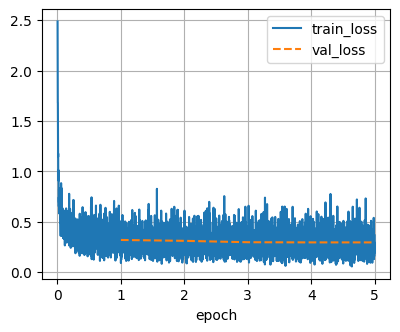

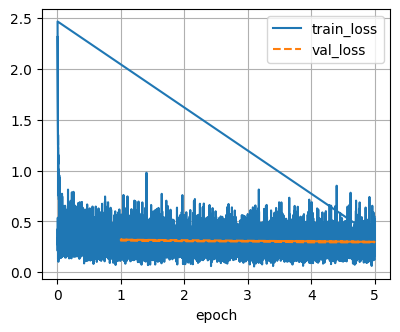

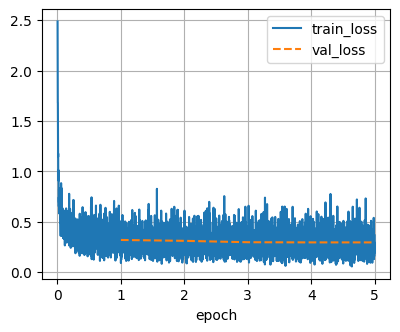

In [18]:
# 重新设置matplotlib环境
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('inline')  # 强制使用notebook内联显示
%matplotlib inline

# 重新创建模型和训练器
model = SoftMaxRegression(config)
plotting_callback = base.PlottingCallback()
trainer = base.Trainer(max_epochs=5, callbacks=[plotting_callback])

print("开始训练...")
trainer.fit(model, train_loader, val_loader)